# 1. Dependencias
---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *


# 2. Carga de datos 
---

In [3]:
df_admission = pd.read_csv("./data/HDHI_admission_data.csv")
df_weather = pd.read_csv("./data/HDHI_pollution_data.csv")

In [ ]:
# Limpiamos y renombramos las columnas originales del df
df_admission.columns = df_admission.columns.str.strip()

mapping = {
    'SNO': 'serial_number',
    'MRD No.': 'mrd_number',
    'D.O.A': 'admission_date',
    'D.O.D': 'discharge_date',
    'AGE': 'age',
    'GENDER': 'gender',
    'RURAL': 'residence_rural',
    'TYPE OF ADMISSION-EMERGENCY/OPD': 'admission_type',
    'month year': 'admission_month_year',
    'DURATION OF STAY': 'length_of_stay_days',
    'duration of intensive unit stay': 'icu_length_of_stay_days',
    'OUTCOME': 'hospital_outcome',
    'SMOKING': 'smoking_status',
    'ALCOHOL': 'alcohol_use',
    'DM': 'diabetes',
    'HTN': 'hypertension',
    'CAD': 'coronary_artery_disease',
    'PRIOR CMP': 'prior_cva',                     # CMP -> cerebrovascular accident 
    'CKD': 'chronic_kidney_disease',
    'HB': 'hemoglobin_g_dl',
    'TLC': 'total_leukocyte_count',
    'PLATELETS': 'platelet_count',
    'GLUCOSE': 'glucose_mg_dl',
    'UREA': 'urea_mg_dl',
    'CREATININE': 'creatinine_mg_dl',
    'BNP': 'bnp',
    'RAISED CARDIAC ENZYMES': 'raised_cardiac_enzymes',
    'EF': 'ejection_fraction_percent',
    'SEVERE ANAEMIA': 'severe_anemia',
    'ANAEMIA': 'anemia',
    'STABLE ANGINA': 'stable_angina',
    'ACS': 'acute_coronary_syndrome',
    'STEMI': 'stemi',
    'ATYPICAL CHEST PAIN': 'atypical_chest_pain',
    'HEART FAILURE': 'heart_failure',
    'HFREF': 'hf_ref',                             # HFrEF (reduced EF)
    'HFNEF': 'hf_nef',                             # HFpEF/HFNEF (preserv. EF)
    'VALVULAR': 'valvular_disease',
    'CHB': 'complete_heart_block',
    'SSS': 'sick_sinus_syndrome',
    'AKI': 'acute_kidney_injury',
    'CVA INFRACT': 'cva_infarct',
    'CVA BLEED': 'cva_bleed',
    'AF': 'atrial_fibrillation',
    'VT': 'ventricular_tachycardia',
    'PSVT': 'psvt',
    'CONGENITAL': 'congenital_heart_disease',
    'UTI': 'urinary_tract_infection',
    'NEURO CARDIOGENIC SYNCOPE': 'neurocardiogenic_syncope',
    'ORTHOSTATIC': 'orthostatic_hypotension',
    'INFECTIVE ENDOCARDITIS': 'infective_endocarditis',
    'DVT': 'deep_vein_thrombosis',
    'CARDIOGENIC SHOCK': 'cardiogenic_shock',
    'SHOCK': 'shock',
    'PULMONARY EMBOLISM': 'pulmonary_embolism',
    'CHEST INFECTION': 'chest_infection'
}

df_admission.rename(columns=mapping, inplace=True)

In [5]:
# Estructura del dataset
df_admission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15757 entries, 0 to 15756
Data columns (total 56 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   serial_number              15757 non-null  int64 
 1   mrd_number                 15757 non-null  object
 2   admission_date             15757 non-null  object
 3   discharge_date             15757 non-null  object
 4   age                        15757 non-null  int64 
 5   gender                     15757 non-null  object
 6   residence_rural            15757 non-null  object
 7   admission_type             15757 non-null  object
 8   admission_month_year       15757 non-null  object
 9   length_of_stay_days        15757 non-null  int64 
 10  icu_length_of_stay_days    15757 non-null  int64 
 11  hospital_outcome           15757 non-null  object
 12  smoking_status             15757 non-null  int64 
 13  alcohol_use                15757 non-null  int64 
 14  diabet

In [6]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE                 737 non-null    object 
 1   AQI                  737 non-null    int64  
 2   PM2.5 AVG            737 non-null    int64  
 3   PM2.5 MIN            737 non-null    int64  
 4   PM2.5 MAX            737 non-null    int64  
 5   PM10 AVG             737 non-null    int64  
 6   PM10 MIN             737 non-null    int64  
 7   PM10 MAX             737 non-null    object 
 8   NO2 AVG              737 non-null    int64  
 9   NO2 MIN              737 non-null    int64  
 10  NO2 MAX              737 non-null    object 
 11  NH3 AVG              737 non-null    int64  
 12  NH3 MIN              737 non-null    int64  
 13  NH3 MAX              737 non-null    int64  
 14  SO2 AVG              737 non-null    int64  
 15  SO2 MIN              737 non-null    int

In [7]:
df_admission.head()

,serial_number,mrd_number,admission_date,discharge_date,age,gender,residence_rural,admission_type,admission_month_year,length_of_stay_days,...,congenital_heart_disease,urinary_tract_infection,neurocardiogenic_syncope,orthostatic_hypotension,infective_endocarditis,deep_vein_thrombosis,cardiogenic_shock,shock,pulmonary_embolism,chest_infection
0,1,234735,4/1/2017,4/3/2017,81,M,R,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0
1,2,234696,4/1/2017,4/5/2017,65,M,R,E,Apr-17,5,...,0,0,0,0,0,0,0,0,0,0
2,3,234882,4/1/2017,4/3/2017,53,M,U,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0
3,4,234635,4/1/2017,4/8/2017,67,F,U,E,Apr-17,8,...,0,0,0,0,0,0,0,0,0,0
4,5,234486,4/1/2017,4/23/2017,60,F,U,E,Apr-17,23,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df_weather.head()

,DATE,AQI,PM2.5 AVG,PM2.5 MIN,PM2.5 MAX,PM10 AVG,PM10 MIN,PM10 MAX,NO2 AVG,NO2 MIN,...,CO AVG,CO MIN,CO MAX,OZONE AVG,OZONE MIN,OZONE MAX,PROMINENT POLLUTENT,MAX TEMP,MIN TEMP,HUMIDITY
0,3/25/2017,75,75,45,210,74,50,110,28,40,...,34,1,49,38,21,70,PM2.5,36,18,32.0
1,3/26/2017,82,82,47,153,75,65,86,29,26,...,32,7,55,30,8,70,PM2.5,38,19,23.0
2,3/27/2017,72,72,63,150,71,45,98,38,34,...,40,10,68,26,18,53,PM2.5,40,20,14.0
3,3/28/2017,80,78,63,88,80,73,87,39,37,...,25,12,48,21,4,71,PM10,40,21,36.0
4,3/29/2017,73,64,53,75,73,63,86,38,36,...,35,20,54,32,6,56,PM10,40,23,31.0


In [9]:
# mapa para convertir 'Apr-17' -> 4, 'Mar-19' -> 3, etc.
_MONTH_MAP = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12,
}

def parse_with_disambiguation(
    df,
    date_col,
    month_hint_col=None,
    admission_col=None,
    los_col=None,
    tolerance=2
):
    """
    Convierte una columna de fechas que viene mezclada (DD/MM/YYYY vs MM/DD/YYYY),
    y si se trata de 'discharge_date', valida usando length_of_stay_days.

    Funcionalidades:
    - Hace dos parses: dayfirst y monthfirst.
    - Si solo uno funciona, usa ese.
    - Si los dos funcionan pero dan meses distintos, usa la pista de month_hint_col (si existe).
    - Si la columna corresponde a una fecha de alta (usa admission_col y los_col),
      recalcula discharge_date = admission_date + length_of_stay_days
      cuando la diferencia entre fechas difiere más que el parámetro `tolerance`.
    """

    raw = df[date_col].astype(str)

    # 1️⃣ Dos intentos de parseo
    d_dayfirst = pd.to_datetime(raw, errors='coerce', dayfirst=True)
    d_monthfirst = pd.to_datetime(raw, errors='coerce', dayfirst=False)

    # 2️⃣ Base: usar el que no sea NaT
    result = d_dayfirst.fillna(d_monthfirst)

    # 3️⃣ Filas ambiguas: ambos válidos pero con meses distintos
    amb_mask = (
        d_dayfirst.notna()
        & d_monthfirst.notna()
        & (d_dayfirst.dt.month != d_monthfirst.dt.month)
    )

    if month_hint_col is not None and month_hint_col in df.columns:
        # Extraer el mes esperado del hint (ej. 'Apr-17' -> 4)
        hint_str = df.loc[amb_mask, month_hint_col].astype(str).str[:3]
        hint_month = hint_str.map(_MONTH_MAP)

        # Elegir según coincidencia con el mes esperado
        use_dayfirst = d_dayfirst.loc[amb_mask].dt.month.eq(hint_month)
        chosen = d_dayfirst.loc[amb_mask].where(use_dayfirst, d_monthfirst.loc[amb_mask])
        result.loc[amb_mask] = chosen
    else:
        # Sin pista → priorizamos month-first
        result.loc[amb_mask] = d_monthfirst.loc[amb_mask]

    # 4️⃣ Si se trata de discharge_date, validar con length_of_stay_days
    if admission_col and los_col and all(col in df.columns for col in [admission_col, los_col]):
        adm = pd.to_datetime(df[admission_col], errors="coerce")
        los = df[los_col]

        # Calcular diferencia actual
        stay_diff = (result - adm).dt.days

        # Detectar inconsistencias (mayor al margen permitido)
        bad_mask = stay_diff.sub(los).abs() > tolerance

        if bad_mask.any():
            print(f"{bad_mask.sum()} fechas inconsistentes detectadas en '{date_col}', recalculando...")

            # Recalcular discharge_date = admission_date + length_of_stay_days
            result.loc[bad_mask] = adm.loc[bad_mask] + pd.to_timedelta(los.loc[bad_mask], unit="D")

        # Verificación final
        new_diff = (result - adm).dt.days
        inconsistentes = (new_diff.sub(los).abs() > tolerance).sum()
        if inconsistentes:
            print(f"{inconsistentes} filas aún no coinciden tras la corrección en '{date_col}'.")

    return result


In [10]:
# Parsear admission_date usando la pista de mes
df_admission['admission_date'] = parse_with_disambiguation(
    df_admission,
    date_col='admission_date',
    month_hint_col='admission_month_year'
)

# Parsear discharge_date verificando coherencia con length_of_stay_days
df_admission['discharge_date'] = parse_with_disambiguation(
    df_admission,
    date_col='discharge_date',
    month_hint_col=None,  # no siempre disponible
    admission_col='admission_date',
    los_col='length_of_stay_days',
    tolerance=2
)


df_weather['DATE'] = pd.to_datetime(
  df_weather['DATE'], 
  dayfirst=False, 
  errors='coerce'
)

df_admission.head(10)

3552 fechas inconsistentes detectadas en 'discharge_date', recalculando...


,serial_number,mrd_number,admission_date,discharge_date,age,gender,residence_rural,admission_type,admission_month_year,length_of_stay_days,...,congenital_heart_disease,urinary_tract_infection,neurocardiogenic_syncope,orthostatic_hypotension,infective_endocarditis,deep_vein_thrombosis,cardiogenic_shock,shock,pulmonary_embolism,chest_infection
0,1,234735,2017-04-01,2017-04-03,81,M,R,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0
1,2,234696,2017-04-01,2017-04-05,65,M,R,E,Apr-17,5,...,0,0,0,0,0,0,0,0,0,0
2,3,234882,2017-04-01,2017-04-03,53,M,U,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0
3,4,234635,2017-04-01,2017-04-08,67,F,U,E,Apr-17,8,...,0,0,0,0,0,0,0,0,0,0
4,5,234486,2017-04-01,2017-04-23,60,F,U,E,Apr-17,23,...,0,0,0,0,0,0,0,0,0,0
5,6,234675,2017-04-01,2017-04-10,44,M,U,E,Apr-17,10,...,0,0,0,0,0,0,0,0,0,0
6,7,234563,2017-04-01,2017-04-06,56,F,U,E,Apr-17,6,...,0,0,0,0,0,0,0,0,0,0
7,8,208455,2017-04-01,2017-04-13,47,M,U,E,Apr-17,13,...,0,0,0,0,0,0,0,0,0,0
8,9,67070,2017-04-01,2017-04-03,65,F,U,E,Apr-17,3,...,0,0,0,0,0,0,0,1,0,0
9,10,153218,2017-04-01,2017-04-03,59,M,U,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df_weather.head(5)

,DATE,AQI,PM2.5 AVG,PM2.5 MIN,PM2.5 MAX,PM10 AVG,PM10 MIN,PM10 MAX,NO2 AVG,NO2 MIN,...,CO AVG,CO MIN,CO MAX,OZONE AVG,OZONE MIN,OZONE MAX,PROMINENT POLLUTENT,MAX TEMP,MIN TEMP,HUMIDITY
0,2017-03-25,75,75,45,210,74,50,110,28,40,...,34,1,49,38,21,70,PM2.5,36,18,32.0
1,2017-03-26,82,82,47,153,75,65,86,29,26,...,32,7,55,30,8,70,PM2.5,38,19,23.0
2,2017-03-27,72,72,63,150,71,45,98,38,34,...,40,10,68,26,18,53,PM2.5,40,20,14.0
3,2017-03-28,80,78,63,88,80,73,87,39,37,...,25,12,48,21,4,71,PM10,40,21,36.0
4,2017-03-29,73,64,53,75,73,63,86,38,36,...,35,20,54,32,6,56,PM10,40,23,31.0


In [12]:
# Mostramos los valores nulos
df_admission.isna().sum().sort_values(ascending=False)

bnp                          8441
ejection_fraction_percent    1505
glucose_mg_dl                 863
total_leukocyte_count         286
platelet_count                285
hemoglobin_g_dl               252
creatinine_mg_dl              247
urea_mg_dl                    241
discharge_date                  1
admission_type                  0
gender                          0
age                             0
admission_date                  0
residence_rural                 0
icu_length_of_stay_days         0
length_of_stay_days             0
hypertension                    0
diabetes                        0
alcohol_use                     0
smoking_status                  0
hospital_outcome                0
admission_month_year            0
mrd_number                      0
serial_number                   0
prior_cva                       0
coronary_artery_disease         0
chronic_kidney_disease          0
raised_cardiac_enzymes          0
severe_anemia                   0
anemia        

###  Imputación de `admission_date` y `discharge_date` faltantes

En algunos registros, la fecha de admisión (`discharge_date`) está ausente (`NaT`), 
pero sí se dispone de la fecha de alta (`admission_date`) y la duración de la internación (`length_of_stay_days`). 

Para estos casos, se puede estimar la fecha utilizando la duracion de la internacion (`length_of_stay_days`).

Esta imputación permite conservar consistencia temporal en los análisis de admisiones y estancias.


In [13]:
# Creamos una máscara para filas con fecha de admisión faltante pero con datos válidos
mask = (
  df_admission['admission_date'].isna() & 
  df_admission['discharge_date'].notna() & 
  df_admission['length_of_stay_days'].notna()
)

# Accedemos a todas las filas donde la mascara sea True y realizamos la imputacion
df_admission.loc[mask, 'admission_date'] = (
  df_admission.loc[mask, 'discharge_date'] - 
  pd.to_timedelta(df_admission.loc[mask, 'length_of_stay_days'], unit='D')
)


In [14]:
# Creamos una máscara para filas con fecha de alta faltante pero con datos válidos
mask = (df_admission['admission_date'].notna() &
        df_admission['length_of_stay_days'].notna() & 
        df_admission['discharge_date'].isna()        
)

df_admission.loc[mask, 'discharge_date'] = (
        df_admission.loc[mask, 'admission_date'] + 
        pd.to_timedelta(df_admission.loc[mask, 'length_of_stay_days'], unit='D')
)

In [15]:
# Eliminamos las filas que tanto 'admission_date' como 'discharge_date' son nulas
df_admission = df_admission.dropna(subset = ['admission_date', 'discharge_date'], how='all')

df_admission.isna().sum().sort_values(ascending=False)

bnp                          8441
ejection_fraction_percent    1505
glucose_mg_dl                 863
total_leukocyte_count         286
platelet_count                285
hemoglobin_g_dl               252
creatinine_mg_dl              247
urea_mg_dl                    241
admission_type                  0
residence_rural                 0
gender                          0
age                             0
discharge_date                  0
admission_month_year            0
icu_length_of_stay_days         0
length_of_stay_days             0
hypertension                    0
diabetes                        0
alcohol_use                     0
smoking_status                  0
hospital_outcome                0
serial_number                   0
admission_date                  0
mrd_number                      0
prior_cva                       0
coronary_artery_disease         0
chronic_kidney_disease          0
raised_cardiac_enzymes          0
severe_anemia                   0
anemia        

In [16]:
# Exportamos df_admission limpio
df_admission.to_csv('./data/cleaned_admission_data.csv', index=False)

# 3. Serie temporal: cantidad de pacientes hospitalizados por día
---

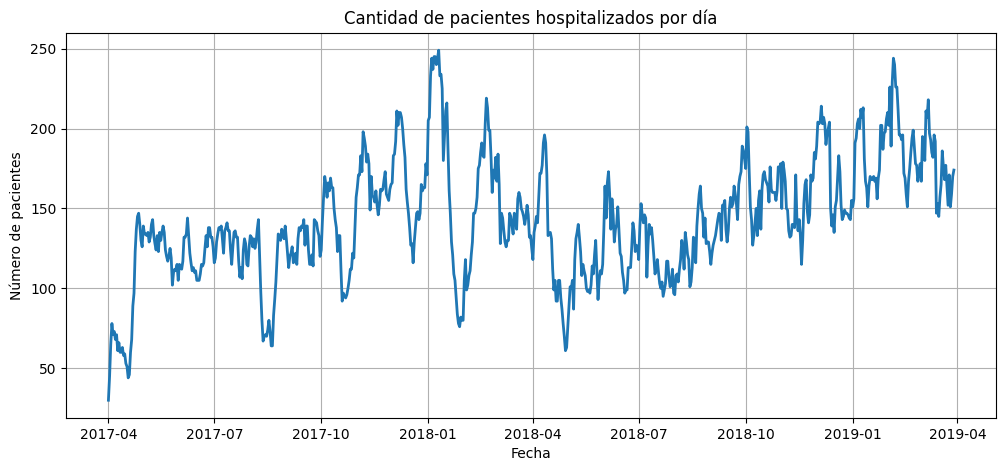

In [17]:

# Expandir el rango de fechas por paciente
df_expanded = (
    df_admission
    .apply(lambda row: pd.date_range(row['admission_date'], row['discharge_date'], freq='D'), axis=1)
    .explode()
    .to_frame(name='date')
)

# Agregar el ID del paciente
df_expanded['serial_number'] = df_admission.loc[df_expanded.index, 'serial_number'].values

# Agrupamos por fecha y contamos
daily_counts = (
    df_expanded
    .groupby('date')
    .size()
    .reset_index(name='num_patients')
)

# Excluimos los ultimos 25 valores ya que sesgan el modelo
daily_counts = daily_counts.iloc[:-25]

# exportar daily_counts a un csv
daily_counts.to_csv('./data/daily_hospitalized_patients.csv', index=False)

# Graficamos la serie temporal
plt.figure(figsize=(12,5))
plt.plot(daily_counts['date'], daily_counts['num_patients'], linewidth=2)
plt.title('Cantidad de pacientes hospitalizados por día')
plt.xlabel('Fecha')
plt.ylabel('Número de pacientes')
plt.grid(True)
plt.show()


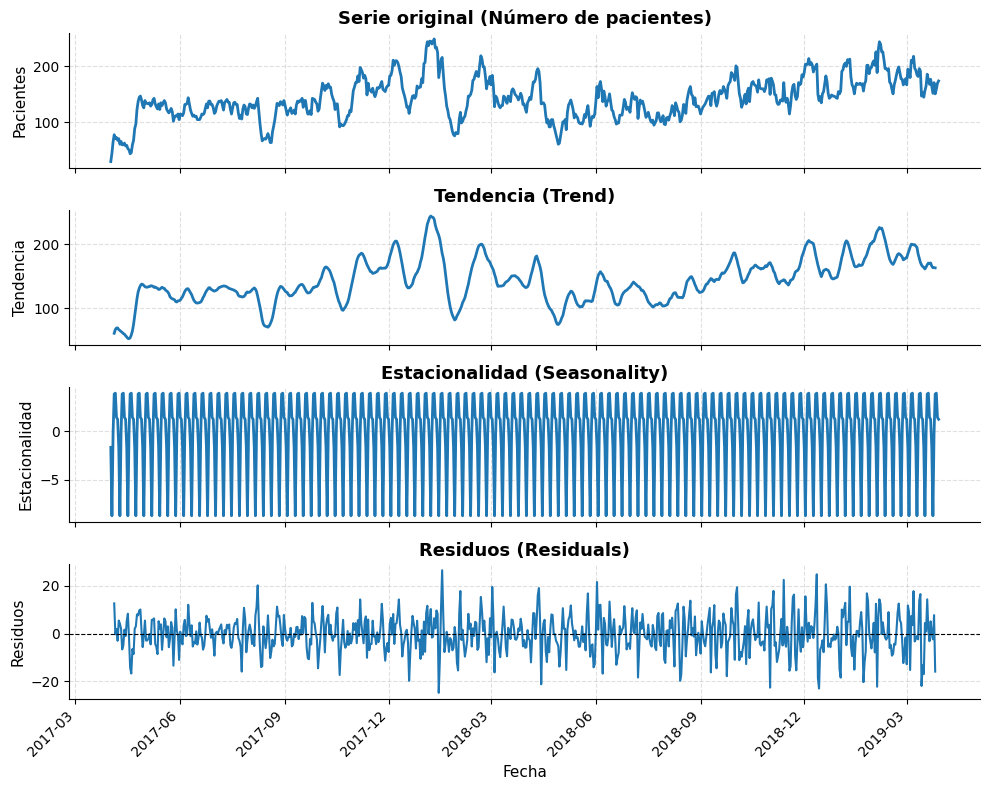

In [18]:
ts = daily_counts.copy()
ts['date'] = pd.to_datetime(ts['date'])
ts = ts.set_index('date').sort_index()

# Asegurar frecuencia diaria y rellenar días faltantes con 0
ts = ts.asfreq('D', fill_value=0)

# Descomposición aditiva (period=7 para estacionalidad semanal)
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts['num_patients'], model='additive', period=7)

# Plot personalizado usando el índice datetime (los formatters funcionarán correctamente)
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Serie original
axes[0].plot(ts.index, result.observed, linewidth=2)
axes[0].set_title('Serie original (Número de pacientes)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Pacientes', fontsize=11)

# Tendencia
axes[1].plot(ts.index, result.trend, linewidth=2)
axes[1].set_title('Tendencia (Trend)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Tendencia', fontsize=11)

# Estacionalidad
axes[2].plot(ts.index, result.seasonal, linewidth=2)
axes[2].set_title('Estacionalidad (Seasonality)', fontsize=13, fontweight='bold')
axes[2].set_ylabel('Estacionalidad', fontsize=11)

# Residuos
axes[3].plot(ts.index, result.resid, linewidth=1.5)
axes[3].axhline(0, color='black', linestyle='--', linewidth=0.8)
axes[3].set_title('Residuos (Residuals)', fontsize=13, fontweight='bold')
axes[3].set_ylabel('Residuos', fontsize=11)
axes[3].set_xlabel('Fecha', fontsize=11)

# --- Formatear eje X con fechas ---
axes[3].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[3].xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # cada 3 meses
fig.autofmt_xdate(rotation=45)

# Ajustes estéticos
for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()




In [19]:
import pandas as pd

df = pd.read_csv("./data/daily_hospitalized_patients.csv")
df['date'] = pd.to_datetime(df['date'])

#¿Está ordenado cronológicamente?
print("¿Fechas en orden ascendente?:", df['date'].is_monotonic_increasing)

#¿Hay días faltantes?
full_range = pd.date_range(df['date'].min(), df['date'].max())
missing_dates = full_range.difference(df['date'])
print(f"Cantidad de días faltantes: {len(missing_dates)}")
if len(missing_dates) > 0:
    print("Ejemplo de fechas faltantes:", missing_dates[:10])

#¿Hay valores nulos?
print("\nValores nulos por columna:")
print(df.isna().sum())


¿Fechas en orden ascendente?: True
Cantidad de días faltantes: 0

Valores nulos por columna:
date            0
num_patients    0
dtype: int64


Total registros: 728
Train: 509 Val: 109 Test: 110
x_train: (496, 7, 1) y_train: (496, 7)
x_val: (96, 7, 1) y_val: (96, 7)
x_test: (97, 7, 1) y_test: (97, 7)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 7, 64)          │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,919 (89.53 KB)

 Trainable params: 22,919 (89.53 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.3703 - mse: 0.1681 - val_loss: 0.2818 - val_mse: 0.1113
Epoch 2/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2001 - mse: 0.0617 - val_loss: 0.1852 - val_mse: 0.0506
Epoch 3/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1392 - mse: 0.0321 - val_loss: 0.1199 - val_mse: 0.0224
Epoch 4/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1085 - mse: 0.0201 - val_loss: 0.1044 - val_mse: 0.0166
Epoch 5/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0971 - mse: 0.0165 - val_loss: 0.1008 - val_mse: 0.0154
Epoch 6/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0949 - mse: 0.0156 - val_loss: 0.1001 - val_mse: 0.0150
Epoch 7/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0950 - mse: 0.0156 - val_loss: 0.1051 - val_mse: 0.0164
Epoch 8/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0933 - mse: 0.0150 - val_loss: 0.1009 - val_mse: 0.0150
Epoch 9/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.09

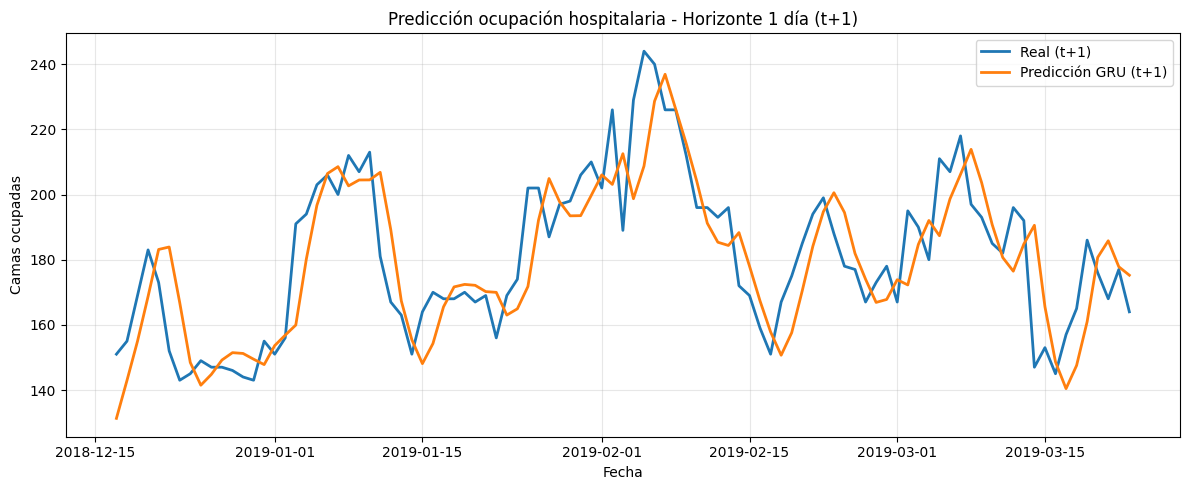

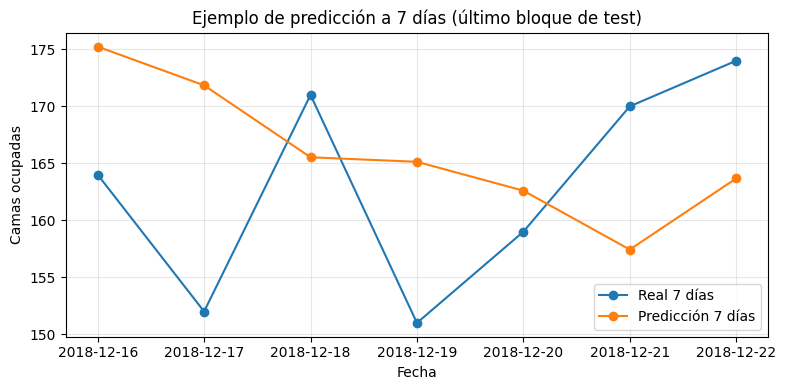

In [2]:
# -----------------------------------------------------------
# 1) IMPORTS Y CONFIGURACIÓN
# -----------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers

DATA_PATH = "./data/daily_hospitalized_patients.csv"
SEQ_LENGTH = 7        # ventana de entrada: 60 días
HORIZON = 7            # predicción: 7 días hacia adelante
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15

# Fijamos semillas aleatorias para hacer el entrenamiento lo más reproducible posible.
import random
np.random.seed(42)
random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# -----------------------------------------------------------
# 2) CARGA Y PREPROCESAMIENTO
# -----------------------------------------------------------
df = pd.read_csv(DATA_PATH, parse_dates=["date"])
df = df.sort_values("date").reset_index(drop=True)

values = df["num_patients"].values.reshape(-1, 1)
dates = df["date"].values

#aca yo a la división la hacemos hace por índices, sin mezclar el orden temporal, lo cual es obligatorio en series.
n = len(values)
train_end = int(n * TRAIN_RATIO)
val_end   = int(n * (TRAIN_RATIO + VAL_RATIO))

train_values = values[:train_end]
val_values   = values[train_end:val_end]
test_values  = values[val_end:]

print("Total registros:", n)
print("Train:", len(train_values), "Val:", len(val_values), "Test:", len(test_values))

# -----------------------------------------------------------
# 3) NORMALIZACIÓN (SOLO TRAIN)
# -----------------------------------------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_values)
val_scaled   = scaler.transform(val_values)
test_scaled  = scaler.transform(test_values)

# -----------------------------------------------------------
# 4) CREACIÓN DE SECUENCIAS (VENTANA -> 7 DÍAS ADELANTE)
# -----------------------------------------------------------
def create_sequences_multistep(data, seq_length, horizon):
    """
    data: array 2D (n, 1) normalizado
    seq_length: longitud de la ventana de entrada
    horizon: cantidad de días a predecir
    return:
        X: (m, seq_length, 1)
        y: (m, horizon)  -> multi-salida
    """
    xs, ys = [], []
    for i in range(len(data) - seq_length - horizon + 1):
        x = data[i : i + seq_length]
        y = data[i + seq_length : i + seq_length + horizon].flatten()
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

x_train, y_train = create_sequences_multistep(train_scaled, SEQ_LENGTH, HORIZON)
x_val,   y_val   = create_sequences_multistep(val_scaled,   SEQ_LENGTH, HORIZON)
x_test,  y_test  = create_sequences_multistep(test_scaled,  SEQ_LENGTH, HORIZON)

print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_val:",   x_val.shape,   "y_val:",   y_val.shape)
print("x_test:",  x_test.shape,  "y_test:",  y_test.shape)

# -----------------------------------------------------------
# 5) MODELO GRU MULTI-SALIDA (7 DÍAS)
# -----------------------------------------------------------
model = keras.Sequential([
    layers.Input(shape=(SEQ_LENGTH, 1)),
    layers.GRU(64, return_sequences=True), 
    layers.Dropout(0.2), #apago el 20% d las ventanas p evitar el overfitting 
    layers.GRU(32), #resume toda la secuencia en un solo vector 
    layers.Dense(16, activation="relu"),  #agrega una transf no lineal
    layers.Dense(HORIZON)  # salida: vector de 7 días
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mae",
    metrics=["mse"]
)

model.summary()

# -----------------------------------------------------------
# 6) ENTRENAMIENTO
# -----------------------------------------------------------
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=12,
    restore_best_weights=True
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=120,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# -----------------------------------------------------------
# 7) EVALUACIÓN GLOBAL EN TEST
# -----------------------------------------------------------
test_loss, test_mse = model.evaluate(x_test, y_test, verbose=0)
print("\n===== MÉTRICAS EN TEST (normalizadas, promedio sobre 7 días) =====")
print(f"MAE normalizado: {test_loss:.4f}")
print(f"MSE normalizado: {test_mse:.4f}")

# -----------------------------------------------------------
# 8) PREDICCIÓN Y DES-ESCALADO
# -----------------------------------------------------------
y_pred_scaled = model.predict(x_test)  # (m, 7)

# Des-escalamos flatten y reconstruimos
y_test_real_flat = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1, HORIZON)
y_pred_real_flat = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(-1, HORIZON)

# -----------------------------------------------------------
# 9) MAE REAL POR HORIZONTE (EN CAMAS)
# -----------------------------------------------------------
mae_por_horizonte = []
for h in range(HORIZON):
    mae_h = np.mean(np.abs(y_test_real_flat[:, h] - y_pred_real_flat[:, h]))
    mae_por_horizonte.append(mae_h)
    print(f"MAE real horizonte t+{h+1}: {mae_h:.2f} camas")

# -----------------------------------------------------------
# 9 BIS) R^2 REAL POR HORIZONTE
# -----------------------------------------------------------
r2_por_horizonte = []
for h in range(HORIZON):
    y_true = y_test_real_flat[:, h]
    y_pred = y_pred_real_flat[:, h]
    
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    
    r2 = 1 - ss_res/ss_tot if ss_tot != 0 else np.nan
    r2_por_horizonte.append(r2)
    
    print(f"R² real horizonte t+{h+1}: {r2:.3f}")

# -----------------------------------------------------------
# 10) GRÁFICO 1: DIA +1 (HORIZONTE 1) EN TODO EL TEST
# -----------------------------------------------------------
num_samples_test = y_test_real_flat.shape[0]
# la primera predicción (t+1) corresponde al índice val_end + SEQ_LENGTH
dates_h1 = df["date"].iloc[val_end + SEQ_LENGTH : val_end + SEQ_LENGTH + num_samples_test].values

y1_real = y_test_real_flat[:, 0]
y1_pred = y_pred_real_flat[:, 0]

plt.figure(figsize=(12, 5))
plt.plot(dates_h1, y1_real, label="Real (t+1)", linewidth=2)
plt.plot(dates_h1, y1_pred, label="Predicción GRU (t+1)", linewidth=2)
plt.xlabel("Fecha")
plt.ylabel("Camas ocupadas")
plt.title("Predicción ocupación hospitalaria - Horizonte 1 día (t+1)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 11) GRÁFICO 2: EJEMPLO DE 7 DÍAS (HORIZONTE COMPLETO)
#     Tomamos la última ventana del test
# -----------------------------------------------------------
idx = -1  # último ejemplo de test
real_7 = y_test_real_flat[idx]
pred_7 = y_pred_real_flat[idx]

# Fechas correspondientes a esos 7 días reales
start_index = val_end + SEQ_LENGTH + idx
dates_7 = df["date"].iloc[start_index : start_index + HORIZON].values

plt.figure(figsize=(8, 4))
plt.plot(dates_7, real_7, marker="o", label="Real 7 días")
plt.plot(dates_7, pred_7, marker="o", label="Predicción 7 días")
plt.xlabel("Fecha")
plt.ylabel("Camas ocupadas")
plt.title("Ejemplo de predicción a 7 días (último bloque de test)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
